### Step 1: **Import Libraries**

In [21]:
import re
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


### Step 2: **Load the Dataset**

In [22]:
import json

# Load the dataset (assuming the file path is '/mnt/data/questions.json' as uploaded)
with open('/content/questions.json', 'r') as file:
    data = json.load(file)

# Extract question texts
questions = [item['question_text'] for item in data]
print(f"Total questions loaded: {len(questions)}")
print(f"Sample question: {questions[0]}")


Total questions loaded: 555
Sample question: What is the thickness of the drywall in the residence? 


In [23]:
# Function to clean question text
def preprocess_text(text):
    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

# Apply preprocessing to each question
questions_cleaned = [preprocess_text(q) for q in questions]
print(f"Sample cleaned question: {questions_cleaned[0]}")


Sample cleaned question: what is the thickness of the drywall in the residence 


In [24]:
# Load pre-trained BERT tokenizer and model from Hugging Face
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Check if CUDA is available and move model to GPU if so
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
def get_bert_embedding(text):
    # Tokenize and encode text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move tensors to GPU if available

    # Get BERT model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Generate embeddings for all questions
question_embeddings = [get_bert_embedding(q) for q in questions_cleaned]
print("Generated embeddings for all questions.")


Generated embeddings for all questions.


In [26]:
# Define the number of clusters based on suggested categories (you can adjust this number)
n_clusters = 7

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(question_embeddings)

# Check a few cluster assignments
print(f"Cluster assignment for first 5 questions: {clusters[:5]}")


Cluster assignment for first 5 questions: [2 1 1 2 1]


In [27]:
# Define a mapping of cluster labels to descriptive categories
cluster_mapping = {
    0: "Material Specification",
    1: "Document Request",
    2: "Installation Requirements",
    3: "Responsibility and Ownership",
    4: "Compliance and Code Requirements",
    5: "Project Status and Tracking",
    6: "Equipment and Component Inquiry"
}

# Assign each question a category based on its cluster label
classified_questions = [
    {"question": q, "classification": cluster_mapping[clusters[i]]}
    for i, q in enumerate(questions)
]


In [30]:
# Convert to DataFrame for easier review
classified_df = pd.DataFrame(classified_questions)
print(classified_df.head())

# Display some questions from each category for verification
for cluster_id, category in cluster_mapping.items():
    print(f"Category: {category}")
    sample_questions = classified_df[classified_df['classification'] == category].head(5)
    for idx, row in sample_questions.iterrows():
        print(f" - {row['question']}")
    print("\n")


                                            question  \
0  What is the thickness of the drywall in the re...   
1   How many filters does JCI owe in their contract?   
2  what CB will the changes resulting from RFI 18...   
3         What's the flooring type in the penthouse?   
4  what CB will the changes resulting from RFI 18...   

              classification  
0  Installation Requirements  
1           Document Request  
2           Document Request  
3  Installation Requirements  
4           Document Request  
Category: Material Specification
 - What are the most recent shop drawings for mechanical piping on the 32nd floor?
 - Please provide the blank PTP PDF file
 - What are the most recent shop drawings for mechanical piping on the 32nd floor?
 - What are the most recent shop drawings for mechanical piping on the 32nd floor?
 - What maintenance materials should be provided for ACT-13


Category: Document Request
 - How many filters does JCI owe in their contract?
 - what CB wi

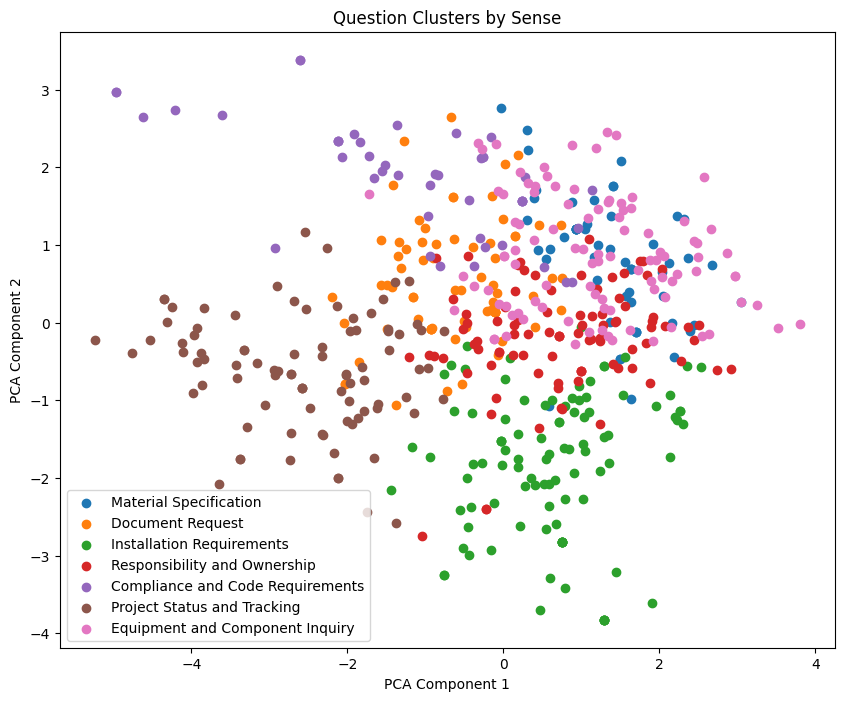

In [31]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(question_embeddings)

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    cluster_points = reduced_embeddings[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_mapping[cluster_id])

plt.legend()
plt.title("Question Clusters by Sense")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [33]:
# Save the classified questions to a CSV file
classified_df.to_csv('classified_questions.csv', index=False)
print("Classified questions saved to 'classified_questions.csv'")


Classified questions saved to 'classified_questions.csv'


In [34]:
# Inertia represents the "loss" for clustering in terms of within-cluster sum of squares
print(f"Inertia (Within-Cluster Sum of Squares): {kmeans.inertia_}")


Inertia (Within-Cluster Sum of Squares): 12021.155633083166


In [35]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(question_embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.05927297845482826


In [36]:
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz score
calinski_harabasz = calinski_harabasz_score(question_embeddings, clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Calinski-Harabasz Index: 21.53506659429898


In [37]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(question_embeddings, clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")


Davies-Bouldin Index: 3.398058784175319


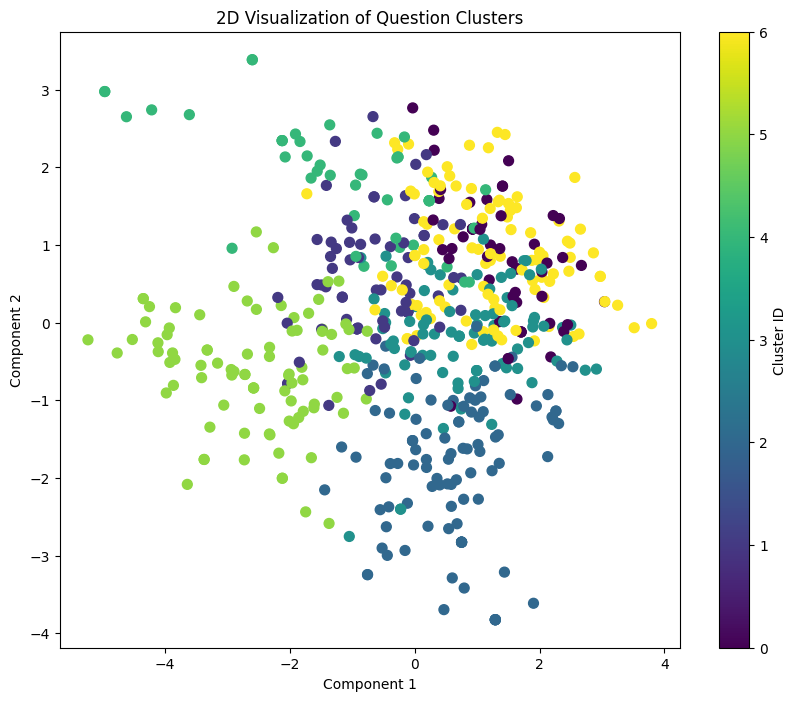

In [38]:
from sklearn.manifold import TSNE

# Convert embeddings to a torch tensor
embeddings_tensor = torch.tensor(question_embeddings)

# Option 1: Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_tensor)

# Option 2: Reduce dimensions with t-SNE for better visualization
# Uncomment this if you'd like to use t-SNE instead of PCA
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(embeddings_tensor)

# Choose pca_result or tsne_result for plotting based on the method used
reduced_embeddings = pca_result  # or tsne_result for t-SNE

# Convert cluster labels to a tensor for easy manipulation
cluster_labels = torch.tensor(clusters)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap="viridis", s=50)
plt.colorbar(scatter, label="Cluster ID")
plt.title("2D Visualization of Question Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()